# Module 03: Assignment for 1-D Diffusion Problem - Thawing Permafrost

## Tryston Sellers

### 1. Introduction and Background

In this notebook you are going to investigate the impact of three climate change scenarios on our previously developed model of the vertical distribution of temperature in a permafrost soil. 


Again, the equation for 1-dimensional heat diffusion into a soil is presented below:
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s, 

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve, 

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

Your __top boundary condition__, we will assume sinusoidal forcing of air temperature superimposed on a linear trend in mean annual temperatures at the surface, with a period of one year. In this notebook we will explore three scenarios. Scenario 1 is a linear increase in mean annual temperature at a rate that results in 1.5 °C of warming by 2100. Scenario 2 is a linear increase in mean annual temperature at a rate that results in 3.0 °C of warming by 2100. Scenario 3 is a linear increase in mean annual temperature at a rate that results in 4.5 °C of warming by 2100. We will start all simulations in 2020. 

Your __bottom boundary condition__, we will assume a constant temperature at the initial mean annual air temperature. 

Your __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 2. Initial Setup

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3] 

dt = 0.25 # Time step [day]

#### 2.1 Load and Plot the Air Temperature Trends

In [3]:
data = np.loadtxt('PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1)

t_year = data[:,0]
T_15 = data[:,1]
T_30 = data[:,2]
T_45 = data[:,3]

Text(0, 0.5, 'Annual average air temperature [°C]')

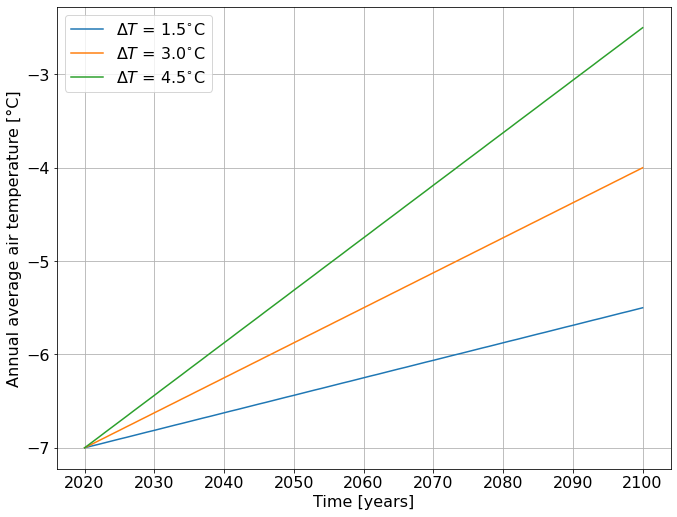

In [5]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')

#### 2.2 Setup the Simulation Time Period

In [6]:
# Time properties of simulation
t0 = t_year[0]
tf = t_year[-1]

t = np.arange(t0,tf+(dt/365),(dt/365))
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  116801


### 3. Setup Boundary Conditions

In [7]:
# Boundary conditions
Ttopamp = 35.0 #also fixed - peak to trough length
Tbottom = -7.0 #fixed - restrictive assumption

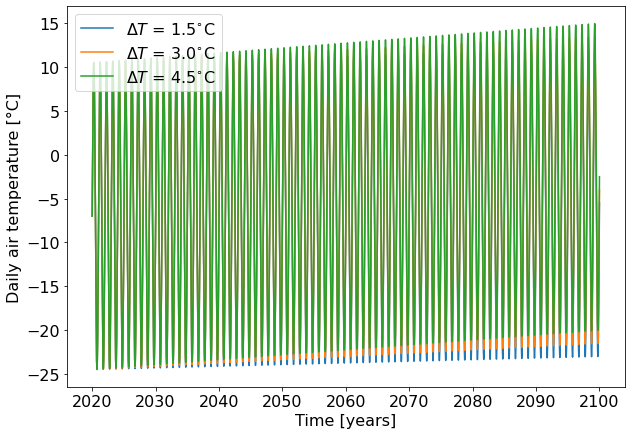

In [8]:
#the temperature increase is gradual over 80 years so each year the Ttop is increasing slightly (.01 or so)
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t) #Ttop boundary conditions for 1.5C increase
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t) #Ttop boundary conditions for 3C increase
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t) #Ttop boundary conditions for 4.5C increase

#plot the sinusoidal boundaries on top of each other
plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

### 4. Setup Spatial Domain

In [9]:
z = np.arange(dz/2, zs, dz) #create an array starting at dz/2 so that we are in the middle of each soil layer with a step size of dz
Nz = z.size #Nz is number of spatial steps
print('Here are the locations of our cells: z = \n' + str(z))
print('The number of cells is: Nz = ',str(Nz))

Here are the locations of our cells: z = 
[  7.5  22.5  37.5  52.5  67.5  82.5  97.5 112.5 127.5 142.5 157.5 172.5
 187.5 202.5 217.5 232.5 247.5 262.5 277.5 292.5 307.5 322.5 337.5 352.5
 367.5 382.5 397.5 412.5 427.5 442.5 457.5 472.5 487.5]
The number of cells is: Nz =  33


### 5. Setup Initial Condition

In [10]:
Ts0 = Tbottom*np.ones((Nz,1)) #the initial temperature is equal to the tbottom

### 6. Calculate $D$, $\mathbf{A}$, and $\mathbf{B}$ Matrices for Implicit or Crank-Nicolson Method

In [11]:
# Calculate diffusivity of permafrost soil
Ds = ks / (rhos * Cs)
print('Soil diffusivity = '+str(Ds)+' m^2/s')

# Convert alpha to units consistent with domain [cm^2/day]
Ds = Ds*(100.0**2)*(24.0*3600.0)
print('Soil diffusivity = '+str(Ds)+' cm^2/day')

alpha = Ds*dt/(dz**2) #this is s from the class notes
print('Diffusion number '+str(alpha))

#Set up matrix A
Delta2 = np.diag(-2.0*np.ones((Nz))) + np.diag(np.ones((Nz-1)),1) + np.diag(np.ones((Nz-1)),-1) #this makes a matrix with 1, -2, 1

#fill out matrix A
I = np.eye(Nz) #this is just an identity matrix
A = I - alpha*Delta2 #this is the identity minus above matrix times s
#[0 1 0] - [s -2s s] = [-s 1+2s -s] which is A from the notes w/out top/bottom boundary conditions
A[0,:] = np.hstack((1.0,np.zeros((Nz-1)))) #this adds a top row starting with 1 and then all zeroes
A[-1,:] = np.hstack((np.zeros((Nz-1)),1.0)) #this adds botom row of all zeroes ending with zeroes
print(A)

#Solve for inverse of A
A1 = np.linalg.pinv(A)
print(A1)

Soil diffusivity = 4.279356384799726e-07 m^2/s
Soil diffusivity = 369.7363916466963 cm^2/day
Diffusion number 0.41081821294077364
[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [-0.41081821  1.82163643 -0.41081821 ...  0.          0.
   0.        ]
 [ 0.         -0.41081821  1.82163643 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.82163643 -0.41081821
   0.        ]
 [ 0.          0.          0.         ... -0.41081821  1.82163643
  -0.41081821]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]
[[ 1.00000000e+00  5.48104584e-16  1.04211336e-16 ...  5.84870806e-17
   2.20558140e-17  1.13987439e-16]
 [ 2.38331579e-01  5.80138784e-01  1.38265392e-01 ...  1.21703434e-17
  -1.91780923e-17 -2.26121005e-17]
 [ 5.68019413e-02  1.38265392e-01  6.13091793e-01 ...  7.59561193e-18
  -1.45672621e-17 -8.10716707e-17]
 ...
 [-6.29796545e-17 -6.44581635e-17 -5.09867978e-17 ...  6.13091793e-01
   1.38265392e-01  5

### 7. Preallocate Storage Memory

In [12]:
Ts_15 = np.zeros((Nz,Nt))
Ts_30 = np.zeros((Nz,Nt))
Ts_45 = np.zeros((Nz,Nt))

### 8. Apply Solution And Compute Temperatures

In [13]:
#Scenario 1: 1.5C increase in temperature
for i in np.arange(Nt):
    
    if(i==0): 
        Ts_15i = Ts0 #at initial time, temperature is the initial condition
    else:
        Ts_15i = Ts_15[:,i-1]
        Ts_15i[0] = Ttop_15[i]
        Ts_15i[-1] = Tbottom
    
    Ts_15ip1 = np.matmul(A1,Ts_15i)
    
    Ts_15[:,i] = np.squeeze(Ts_15ip1)

#Scenario 2: 3C increase in temperature
for i in np.arange(Nt):
    
    if(i==0): 
        Ts_30i = Ts0 #at initial time, temperature is the initial condition
    else:
        Ts_30i = Ts_30[:,i-1]
        Ts_30i[0] = Ttop_30[i]
        Ts_30i[-1] = Tbottom
    
    Ts_30ip1 = np.matmul(A1,Ts_30i)
    
    Ts_30[:,i] = np.squeeze(Ts_30ip1)
    
#Scenario 3: 4.5C increase in temperature
for i in np.arange(Nt):
    
    if(i==0): 
        Ts_45i = Ts0 #at initial time, temperature is the initial condition
    else:
        Ts_45i = Ts_45[:,i-1]
        Ts_45i[0] = Ttop_45[i]
        Ts_45i[-1] = Tbottom
    
    Ts_45ip1 = np.matmul(A1,Ts_45i)
    
    Ts_45[:,i] = np.squeeze(Ts_45ip1)

### 9. Plot Results, Analyze, and Interpret

Create plots of the following:

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T$ = 1.5${}^{\circ}$C, the middle being $\Delta T$ = 3.0${}^{\circ}$C, and the bottom row being $\Delta T$ = 4.5${}^{\circ}$C. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.
2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm. 
3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.  

## 1. First 10 years and Final 10 years

### 1.a Getting the Arrays

In [21]:
#time step is 0.25 days, 1,460 time steps in one year
day = 1
dtr = (day/dt)*365 #required time steps for one year
print(dtr)
print(t[14600])

t2030 = t[0:14600] #first 10 years
t2100 = t[116801-14600:-1] #final 10 years

#set up temperature indices
Ts_15_2030 = Ts_15[:,0:14600]
Ts_15_2100 = Ts_15[:,116801-14600:-1]

Ts_30_2030 = Ts_30[:,0:14600]
Ts_30_2100 = Ts_30[:,116801-14600:-1]

Ts_45_2030 = Ts_45[:,0:14600]
Ts_45_2100 = Ts_45[:,116801-14600:-1]

1460.0
2029.9999999998545


### 1.b Plotting

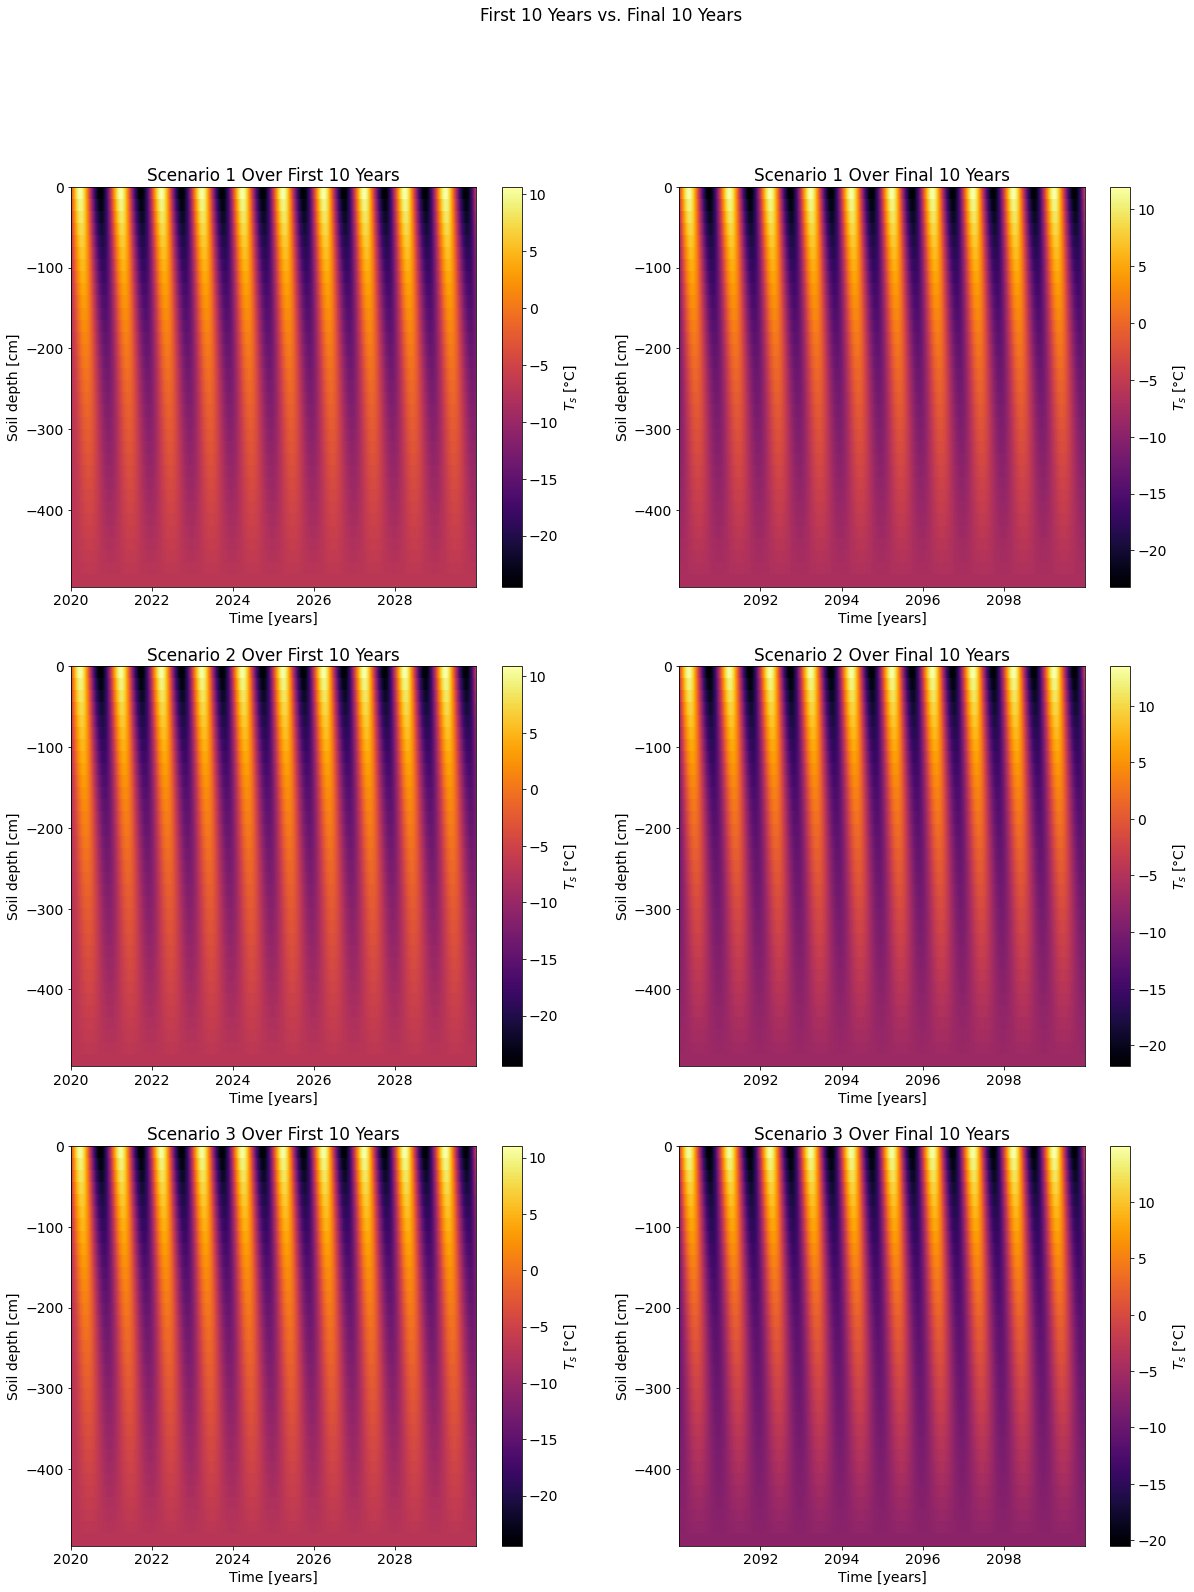

In [22]:
fig = plt.figure(figsize=(20,25))
plt.rcParams.update({'font.size': 14})
fig.suptitle("First 10 Years vs. Final 10 Years")

tti,zzi = np.meshgrid(t2030,z)
ttf,zzf = np.meshgrid(t2100,z)

#scenario 1 first 10 years
ax1 = plt.subplot(3,2,1)
plt.pcolormesh(tti,-zzi,Ts_15_2030,cmap='inferno',shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax1.title.set_text('Scenario 1 Over First 10 Years')

#scenario 1 last 10 years
ax2 = plt.subplot(3,2,2)
plt.pcolormesh(ttf,-zzf,Ts_15_2100,cmap='inferno',shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax2.title.set_text('Scenario 1 Over Final 10 Years')

#scenario 2 first 10 years
ax3 = plt.subplot(3,2,3)
plt.pcolormesh(tti,-zzi,Ts_30_2030,cmap='inferno',shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax3.title.set_text('Scenario 2 Over First 10 Years')

#scenario 2 last 10 years
ax4 = plt.subplot(3,2,4)
plt.pcolormesh(ttf,-zzf,Ts_30_2100,cmap='inferno',shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax4.title.set_text('Scenario 2 Over Final 10 Years')

#scenario 3 first 10 years
ax5 = plt.subplot(3,2,5)
plt.pcolormesh(tti,-zzi,Ts_45_2030,cmap='inferno',shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax5.title.set_text('Scenario 3 Over First 10 Years')

#scenario 3 last 10 years
ax6 = plt.subplot(3,2,6)
plt.pcolormesh(ttf,-zzf,Ts_45_2100,cmap='inferno',shading='auto') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax6.title.set_text('Scenario 3 Over Final 10 Years')

## 2. Temperature at Various Depths

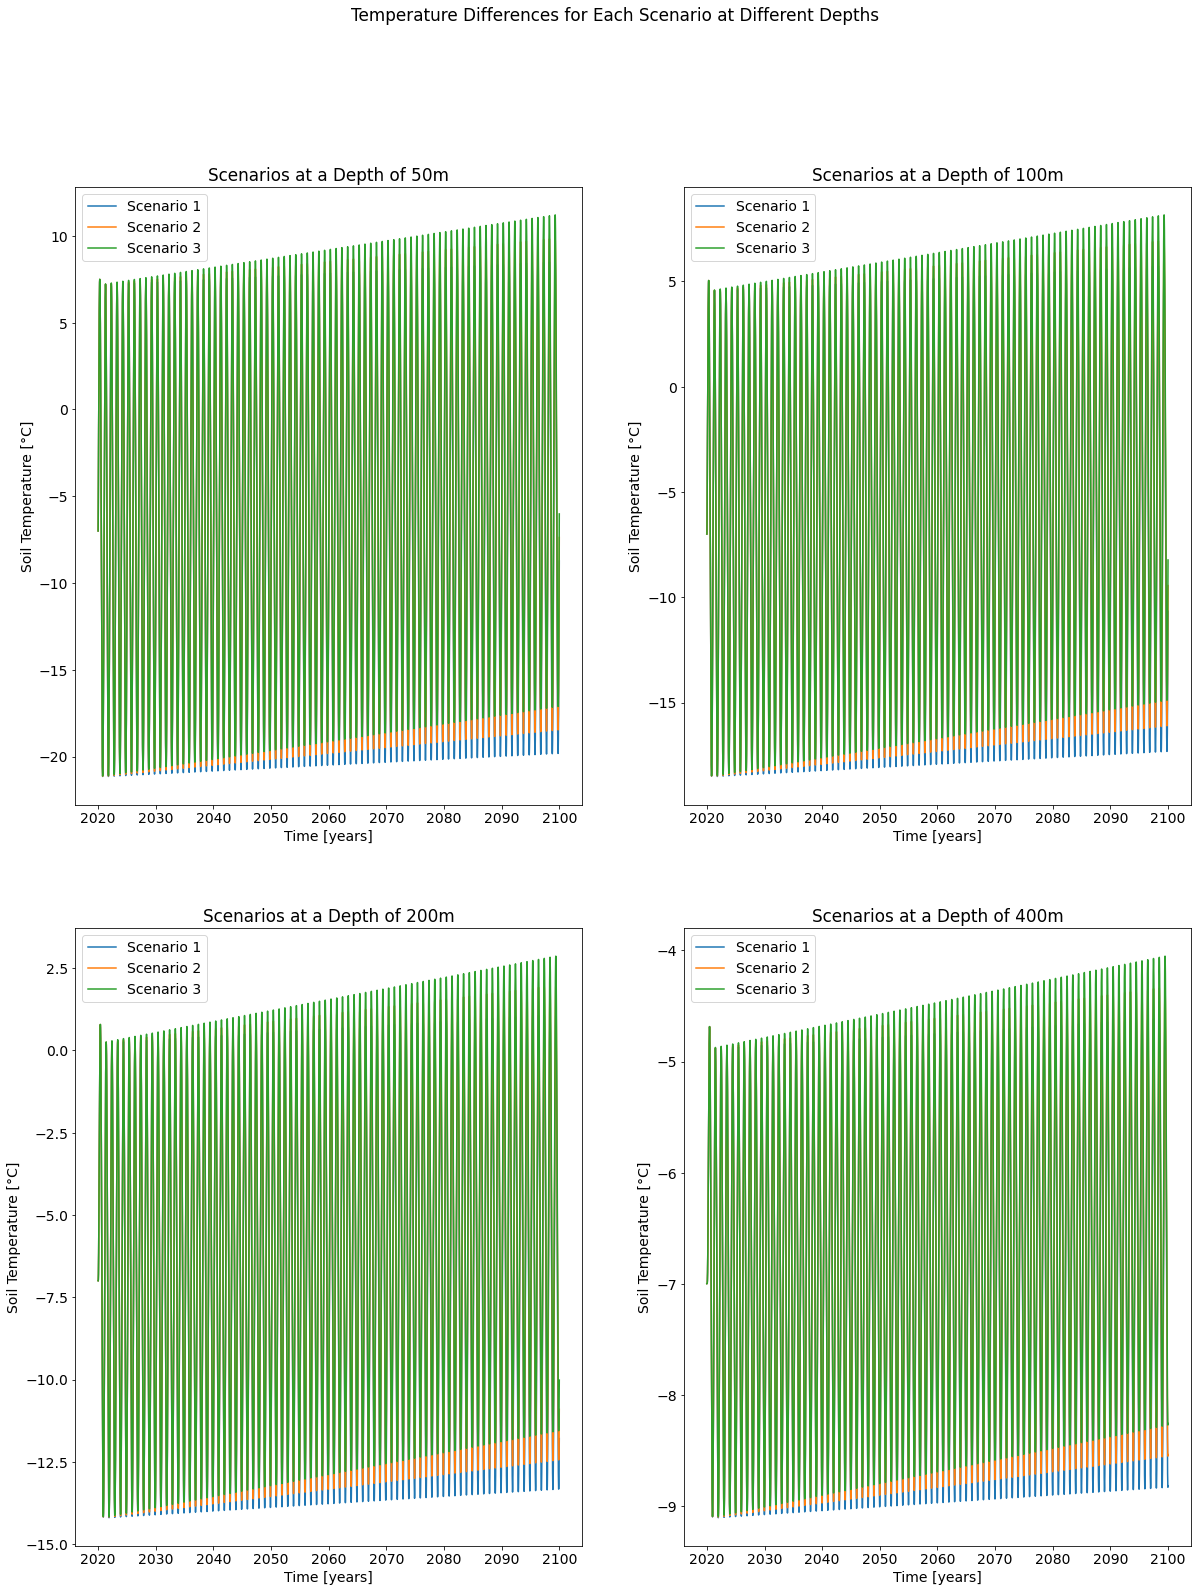

In [24]:
#finding depths
iz50 = (np.absolute(z-50.0)).argmin()
iz100 = (np.absolute(z-100.0)).argmin()
iz200 = (np.absolute(z-200.0)).argmin()
iz400 = (np.absolute(z-400.0)).argmin()

#set up overall figure
fig2 = plt.figure(figsize=(20,25))
plt.rcParams.update({'font.size': 14})
fig2.suptitle("Temperature Differences for Each Scenario at Different Depths")

#50m depth
ax7 = plt.subplot(2,2,1) 
plt.plot(t,Ts_15[iz50,:],label='Scenario 1')
plt.plot(t,Ts_30[iz50,:],label='Scenario 2')
plt.plot(t,Ts_45[iz50,:],label='Scenario 3')
plt.xlabel('Time [years]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()
ax7.title.set_text('Scenarios at a Depth of 50m')

#100m depth
ax8 = plt.subplot(2,2,2) 
plt.plot(t,Ts_15[iz100,:],label='Scenario 1')
plt.plot(t,Ts_30[iz100,:],label='Scenario 2')
plt.plot(t,Ts_45[iz100,:],label='Scenario 3')
plt.xlabel('Time [years]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()
ax8.title.set_text('Scenarios at a Depth of 100m')

#200m depth
ax9 = plt.subplot(2,2,3) 
plt.plot(t,Ts_15[iz200,:],label='Scenario 1')
plt.plot(t,Ts_30[iz200,:],label='Scenario 2')
plt.plot(t,Ts_45[iz200,:],label='Scenario 3')
plt.xlabel('Time [years]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()
ax9.title.set_text('Scenarios at a Depth of 200m')

#400m depth
ax10 = plt.subplot(2,2,4) 
plt.plot(t,Ts_15[iz400,:],label='Scenario 1')
plt.plot(t,Ts_30[iz400,:],label='Scenario 2')
plt.plot(t,Ts_45[iz400,:],label='Scenario 3')
plt.xlabel('Time [years]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()
ax10.title.set_text('Scenarios at a Depth of 400m')

## 3. Table for Each Scenario Showing the Deph of the Active Layer at the First, Middle & Final Decade

### 3.a Setting up arrays for decades

In [25]:
#rewriting the time arrays from above so that they are altogether and adding one for a middle decade

#reminder:time step is 0.25 days, 1,460 time steps in one year

#figure out time indices for the middle decade
tmf = 116801-(14600*3.5)
tmi = tmf-14600
print('the first time indice is ' + str(tmi) + ' and the last time indice is ' + str(tmf))

#shrink time arrays to desired decades
t2030 = t[0:14600] #first 10 years
t2065 = t[51101:65701] #2055-2065
t2100 = t[116801-14600:-1] #final 10 years
print(t2065) #verify correct decade

the first time indice is 51101.0 and the last time indice is 65701.0
[2055.00068493 2055.00136986 2055.00205479 ... 2064.99863014 2064.99931507
 2065.        ]


### 3.b Make temperature arrays

In [26]:
#Copy temperature arrays from above so all together and add middle decade
Ts_15_2030 = Ts_15[:,0:14600]
Ts_15_2065 = Ts_15[:,51101:65701]
Ts_15_2100 = Ts_15[:,116801-14600:-1]

Ts_30_2030 = Ts_30[:,0:14600]
Ts_30_2065 = Ts_30[:,51101:65701]
Ts_30_2100 = Ts_30[:,116801-14600:-1]

Ts_45_2030 = Ts_45[:,0:14600]
Ts_45_2065 = Ts_45[:,51101:65701]
Ts_45_2100 = Ts_45[:,116801-14600:-1]

tti,zzi = np.meshgrid(t2030,z)
ttm,zzm = np.meshgrid(t2065,z)
ttf,zzf = np.meshgrid(t2100,z)

#make matrix that masks values greater than 0 degrees to show active layer
#first scenario
Ts_15frozen_i = np.ma.masked_where(Ts_15_2030>0.0,Ts_15_2030)
Ts_15frozen_m = np.ma.masked_where(Ts_15_2065>0.0,Ts_15_2065)
Ts_15frozen_f = np.ma.masked_where(Ts_15_2100>0.0,Ts_15_2100)

#second scenario
Ts_30frozen_i = np.ma.masked_where(Ts_30_2030>0.0,Ts_30_2030)
Ts_30frozen_m = np.ma.masked_where(Ts_30_2065>0.0,Ts_30_2065)
Ts_30frozen_f = np.ma.masked_where(Ts_30_2100>0.0,Ts_30_2100)

#third scenario
Ts_45frozen_i = np.ma.masked_where(Ts_45_2030>0.0,Ts_45_2030)
Ts_45frozen_m = np.ma.masked_where(Ts_45_2065>0.0,Ts_45_2065)
Ts_45frozen_f = np.ma.masked_where(Ts_45_2100>0.0,Ts_45_2100)

### 3.c Plotting active layers

<ipython-input-37-e8027b688d53>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  current_cmap.set_bad(color='blue')
<ipython-input-37-e8027b688d53>:19: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  current_cmap.set_bad(color='blue')
<ipython-input-37-e8027b688d53>:29: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. 

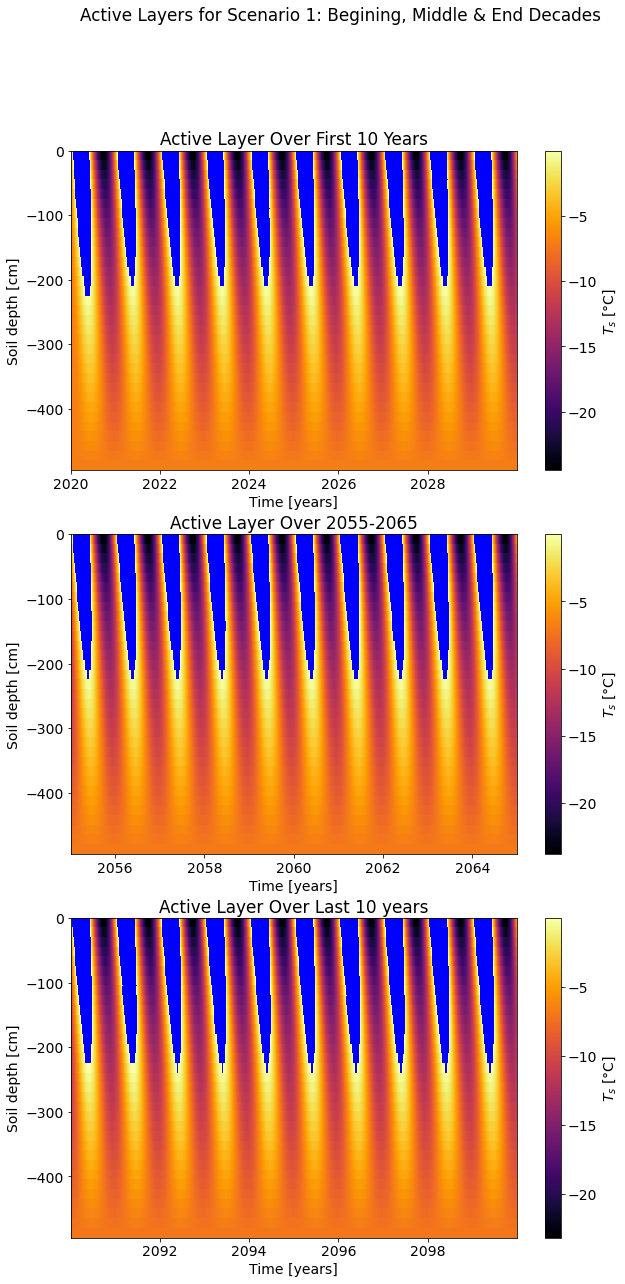

In [37]:
#scenario 1
fig3 = plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 14})
fig3.suptitle("Active Layers for Scenario 1: Begining, Middle & End Decades")

#first decade
ax11 = plt.subplot(3,1,1)
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
plt.pcolormesh(tti,-zzi,Ts_15frozen_i,cmap=current_cmap,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax11.title.set_text('Active Layer Over First 10 Years')

#middle decade
ax12 = plt.subplot(3,1,2)
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
plt.pcolormesh(ttm,-zzm,Ts_15frozen_m,cmap=current_cmap,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax12.title.set_text('Active Layer Over 2055-2065')

#Last decade
ax13 = plt.subplot(3,1,3)
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
plt.pcolormesh(ttf,-zzf,Ts_15frozen_f,cmap=current_cmap,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax13.title.set_text('Active Layer Over Last 10 years')

<ipython-input-38-63fc408f900b>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  current_cmap.set_bad(color='blue')
<ipython-input-38-63fc408f900b>:19: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  current_cmap.set_bad(color='blue')
<ipython-input-38-63fc408f900b>:29: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. 

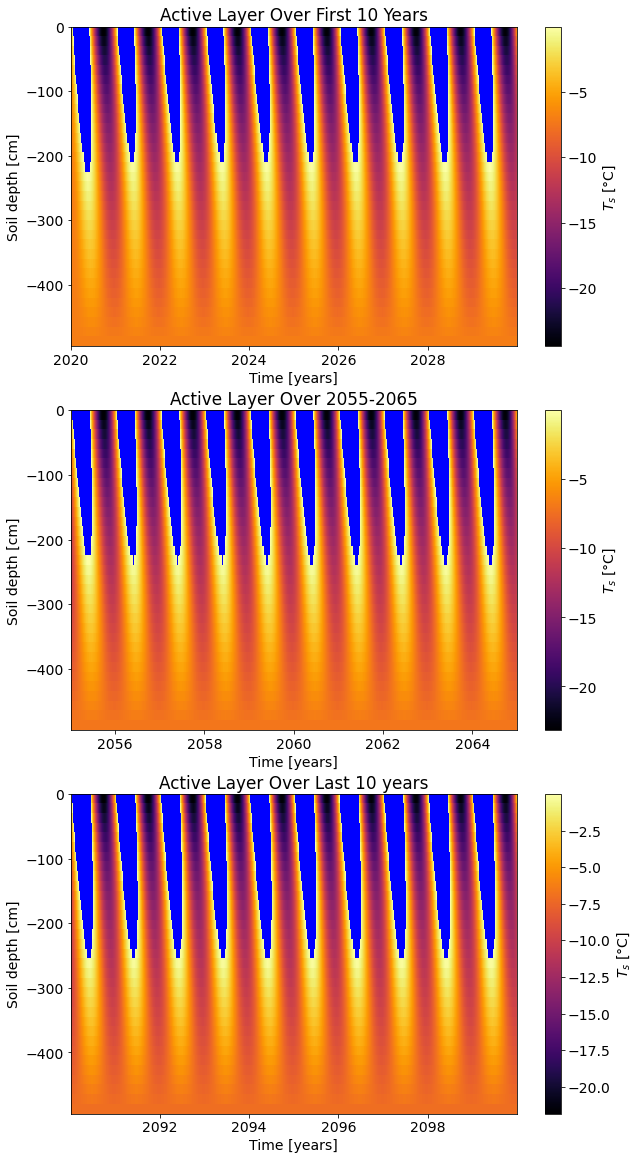

In [38]:
#scenario 2
fig4 = plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 14})
fig4.suptitle("Active Layers for Scenario 2: Begining, Middle & End Decades")

#first decade
ax14 = plt.subplot(3,1,1)
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
plt.pcolormesh(tti,-zzi,Ts_30frozen_i,cmap=current_cmap,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax14.title.set_text('Active Layer Over First 10 Years')

#middle decade
ax15 = plt.subplot(3,1,2)
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
plt.pcolormesh(ttm,-zzm,Ts_30frozen_m,cmap=current_cmap,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax15.title.set_text('Active Layer Over 2055-2065')

#Last decade
ax16 = plt.subplot(3,1,3)
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
plt.pcolormesh(ttf,-zzf,Ts_30frozen_f,cmap=current_cmap,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax16.title.set_text('Active Layer Over Last 10 years')

<ipython-input-39-5add42908242>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  current_cmap.set_bad(color='blue')
<ipython-input-39-5add42908242>:19: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  current_cmap.set_bad(color='blue')
<ipython-input-39-5add42908242>:29: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. 

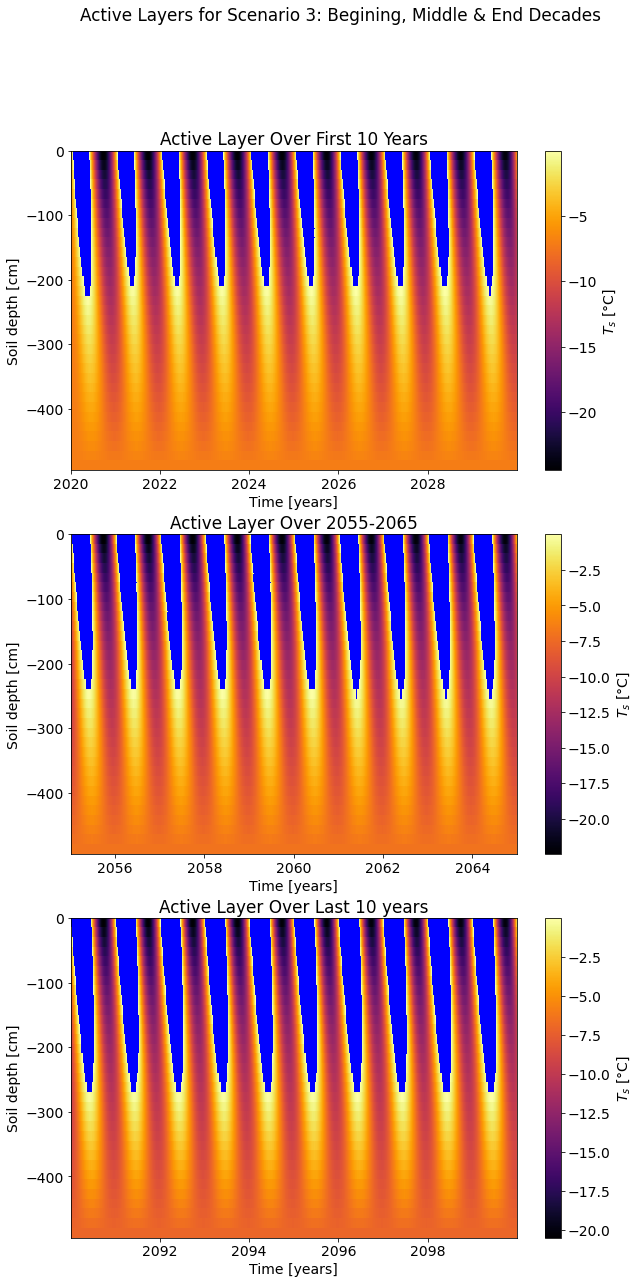

In [39]:
#scenario 3
fig5 = plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 14})
fig5.suptitle("Active Layers for Scenario 3: Begining, Middle & End Decades")

#first decade
ax17 = plt.subplot(3,1,1)
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
plt.pcolormesh(tti,-zzi,Ts_45frozen_i,cmap=current_cmap,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax17.title.set_text('Active Layer Over First 10 Years')

#middle decade
ax18 = plt.subplot(3,1,2)
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
plt.pcolormesh(ttm,-zzm,Ts_45frozen_m,cmap=current_cmap,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax18.title.set_text('Active Layer Over 2055-2065')

#Last decade
ax19 = plt.subplot(3,1,3)
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
plt.pcolormesh(ttf,-zzf,Ts_45frozen_f,cmap=current_cmap,shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [years]')
plt.ylabel('Soil depth [cm]')
ax19.title.set_text('Active Layer Over Last 10 years')

- A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.

### Table 1: Approximate Active Layers (cm) over the First, Middle & Last Decades
***
Scenario |First Decade (2020-2030) |Middle Decade (2055-2065)|Last Decade (2090-2100) 
:----:|------:|----:|----:
One (1.5°C)|200|230|250
Two (3.0°C)|210|245|260
Three (4.5°C)|215|250|275